In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
import gym_combrf

In [4]:
import math
mab_env = gym.make('combrf-v4')

print(mab_env.ch_model)
print(mab_env.sc_xyz)

inp_fptr = open("ricianch_variation.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]

uma-los
[]


## Implement UCB for a stationary environment

#basic implementation
import math
N = 10000
d = env.action_space.n
selected_actions = []

Qvals = [0]*d
num_selections = [0]*d 
total_rwd = 0
alpha=0.7

for n in range(N):
    action_ndx = env.reset(0,0)
    max_upperbound =0
    for i in range(d):
        if(num_selections[i] > 0):
            avg_rwd = Qvals[i]/num_selections[i]
            delta_i = math.sqrt(2*math.log(n+1)/num_selections[i])
            upper_bound = (1-alpha)*avg_rwd + (alpha)*delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upperbound:
            max_upperbound = upper_bound
            action_ndx = i
    
    selected_actions.append(action_ndx)
    num_selections[action_ndx] += 1
    rwd, done = env.step(action_ndx)
    Qvals[action_ndx] += rwd
    total_rwd += rwd
print("total rwd after {} episodes: {}".format(N,total_rwd))

indices = [(0,0),(0,1),(0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
for loc in indices:
    i, j = loc[0], loc[1]#int(loc_ndx / 2), int(loc_ndx % 2)
    #print(i,j)
    env.reset(i,j)
    
    best_action_ndx = Qvals.index(max(Qvals))
    best_tx_dir_ndx = int(best_action_ndx/env.N_tx)
    best_rx_dir_ndx = int(best_action_ndx%env.N_rx)
    
    rwd, done = env.step(best_action_ndx)
    print("best beam pair for tx_loc {}:({}, {}), reward: {}".format(env.tx_loc, env.BeamSet[best_tx_dir_ndx]*180/np.pi ,env.BeamSet[best_rx_dir_ndx]*180/np.pi, rwd))
    

In [5]:
#MAB for one location
def implement_gUCB(n, num_actions, env, tx_loc, txbdir_ndx, Qvals, num_selections, ch_randval):
    
    totalrwd = 0
    alpha = 0.999
    selected_actions = []
    ep_datarates = []
    
    #for n in range(N):
    action_ndx = env.reset(tx_loc, tbdir_ndx, ch_randval)
    max_upperbound = 0
    for i in range(num_actions):
        if(num_selections[i] > 0):
            avg_rwd = Qvals[i] / num_selections[i]
            delta_i = math.sqrt(2*math.log(n+1)/num_selections[i])
            upper_bound = (1-alpha)*avg_rwd + (alpha)*delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upperbound:
            max_upperbound = upper_bound
            action_ndx = i
    selected_actions.append(action_ndx)
    num_selections[action_ndx] += 1
    rwd, done = env.step(action_ndx)
    #ep_datarates.append(env.get_rate())
    Qvals[action_ndx] += rwd
    #totalrwd += rwd
    expected_rwdvals = [x/y if (y>0) else 0 for x,y in zip(Qvals,num_selections)]
    best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
    datarate = env.compute_data_rate(best_action_ndx)
    min_exhrate, max_exhrate, min_action_ndx, max_action_ndx, _, _ = env.get_minmax_exhrate(ch_randval)        
    return rwd, best_action_ndx, datarate, min_exhrate, max_exhrate

In [6]:
#learn best beam directions for each TX location using MAB
# Store the learnt beam directions into a dictionary/numpy array
N=4100
num_actions = mab_env.action_space.n

tx_locs =[]
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        for zloc in mab_env.rx_zcov:
            tx_locs.append(np.array([[xloc, yloc, zloc]]))
        
BeamMap = {}
Loc_Qvals = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_numselections = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
train_datarates =[]
Loc_count = [0 for i in range(num_actions*len(tx_locs))]
        
totalrwd = 0
for loc_ndx in range(len(tx_locs)):
    mab_env = gym.make('combrf-v4')
    tx_loc = tx_locs[loc_ndx]
#    if(np.all(tx_loc == np.array([[-100,-100,0]]))):
#           print(tx_loc, loc_ndx)
    #for tbdir_ndx in range(num_actions):
    #mab_env = gym.make('combrf-v4')
    for n in range(N):
        tbdir_ndx = mab_env.action_space.sample()
        #if (n % 50 == 0):
        #mab_env.sc_xyz = eps_scpts[n]
        #loc_ndx = np.random.randint(0,len(tx_locs))

        #Qvals = [0]*num_actions
        #num_selections = [0]*num_actions
        #Loc_count[loc_ndx*num_actions+tbdir_ndx] += 1
        #k = Loc_count[loc_ndx*num_actions+tbdir_ndx]
        #k=n
        #print("Before: ",Loc_Qvals[loc_ndx*num_actions+tbdir_ndx])
        rwd, best_action_ndx, datarate, min_exhrate, max_exhrate= implement_gUCB(n, num_actions, mab_env, tx_loc,tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], ch_randvals[n])

        #print("After: ", Loc_Qvals[loc_ndx*num_actions+tbdir_ndx])
        totalrwd += rwd
        train_datarates.append(datarate)
        #Loc_Qvals.append(Qvals)
        #Loc_numselections.append(num_selections)
        #expected_rwdvals = [ x/y if (y>0) else 0 for x,y in zip(Loc_Qvals[tbdir_ndx],Loc_numselections[tbdir_ndx])]
        #best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
        BeamMap[str(tx_loc[0][0])+','+ str(tx_loc[0][1]) + ',' +str(tx_loc[0][2])+','+str(tbdir_ndx)] = best_action_ndx


In [7]:
#Test MAB over a selected location
#Apply same channel values to BeamMap and DQN
N_iter = 100
selected_chvals = ch_randvals[4100:4100+N_iter]
selected_loc = np.array([[-100,-100,21.5]])
mabtest_datarates = []
mabtestmin_exhrates =[]
mabtestmax_exhrates =[]

#Task1: Update MAB BeamMap with selected channelvals
loc_ndx = 0
break_flag = False
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        for zloc in mab_env.rx_zcov:
            tx_loc = np.array([[xloc, yloc, zloc]])
            if (np.all(tx_loc == selected_loc)):
                break_flag = True
                break
            if break_flag:
                break
            loc_ndx = loc_ndx +1
        if break_flag:
            break
        
            
tbdir_ndx = 0            
for i in range(N_iter):    
    print("tbdir_ndx: {}, loc_ndx: {}".format(tbdir_ndx, loc_ndx))
    #Qvals = Loc_Qvals[loc_ndx+tbdir_ndx]
    #num_selections = Loc_numselections[loc_ndx+tbdir_ndx]
    #if ((4100+i) % 50 == 0):
    #mab_env.sc_xyz = eps_scpts[4100+i]
    totalrwd, best_action_ndx, datarate, min_exhrate, max_exhrate= implement_gUCB(i, num_actions, mab_env, selected_loc, tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], selected_chvals[i])
    
    #Loc_Qvals[loc_ndx+tbdir_ndx]= Qvals
    #Loc_numselections[loc_ndx+tbdir_ndx]=num_selections
    
    mabtest_datarates.append(datarate)
    mabtestmin_exhrates.append(min_exhrate)
    mabtestmax_exhrates.append(max_exhrate)
    
    BeamMap[str(selected_loc[0][0])+','+ str(selected_loc[0][1]) + ',' +str(selected_loc[0][2])+','+str(tbdir_ndx)] = best_action_ndx
    tbdir_ndx = (tbdir_ndx +1) % 8


for tbdir_ndx in range(mab_env.N_tx):
    print('loc: {}, tbdir_ndx: {}, best_action_ndx: {}'.format(selected_loc, tbdir_ndx, BeamMap[str(selected_loc[0][0])+','+ str(selected_loc[0][1]) + ',' +str(selected_loc[0][2])+','+str(tbdir_ndx)]))

tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2


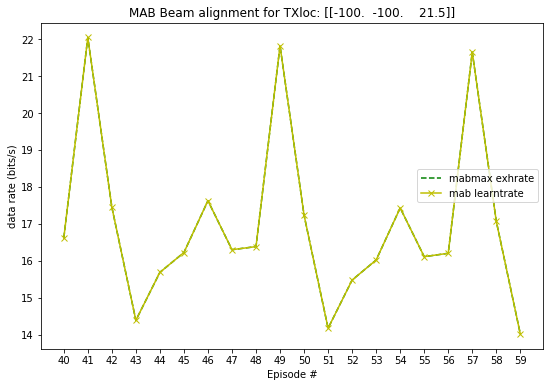

In [12]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
plt.plot(np.arange(len(mabtest_datarates[min_ndx:max_ndx])), mabtestmax_exhrates[min_ndx:max_ndx], 'g--', np.arange(len(mabtest_datarates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['mabmax exhrate', 'mab learntrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('MAB Beam alignment for TXloc: {}'.format(selected_loc))
plt.show()

## Location variation using MAB

In [13]:
N=4100
num_actions = mab_env.action_space.n

tx_locs =[]
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        for zloc in mab_env.rx_zcov:
            tx_locs.append(np.array([[xloc, yloc, zloc]]))
        
BeamMap = {}
Loc_Qvals = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_numselections = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
train_datarates =[]
Loc_count = [0 for i in range(num_actions*len(tx_locs))]
        
totalrwd = 0
for loc_ndx in range(len(tx_locs)-2):
    mab_env = gym.make('combrf-v4')
    tx_loc = tx_locs[loc_ndx]
#    if(np.all(tx_loc == np.array([[-100,-100,0]]))):
#           print(tx_loc, loc_ndx)
    #for tbdir_ndx in range(num_actions):
    #mab_env = gym.make('combrf-v4')
    for n in range(N):
        tbdir_ndx = mab_env.action_space.sample()
        #if (n % 50 == 0):
        #mab_env.sc_xyz = eps_scpts[n]
        #loc_ndx = np.random.randint(0,len(tx_locs))

        #Qvals = [0]*num_actions
        #num_selections = [0]*num_actions
        #Loc_count[loc_ndx*num_actions+tbdir_ndx] += 1
        #k = Loc_count[loc_ndx*num_actions+tbdir_ndx]
        #k=n
        #print("Before: ",Loc_Qvals[loc_ndx*num_actions+tbdir_ndx])
        rwd, best_action_ndx, datarate, min_exhrate, max_exhrate= implement_gUCB(n, num_actions, mab_env, tx_loc,tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], ch_randvals[n])

        #print("After: ", Loc_Qvals[loc_ndx*num_actions+tbdir_ndx])
        totalrwd += rwd
        train_datarates.append(datarate)
        #Loc_Qvals.append(Qvals)
        #Loc_numselections.append(num_selections)
        #expected_rwdvals = [ x/y if (y>0) else 0 for x,y in zip(Loc_Qvals[tbdir_ndx],Loc_numselections[tbdir_ndx])]
        #best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
        BeamMap[str(tx_loc[0][0])+','+ str(tx_loc[0][1]) + ',' +str(tx_loc[0][2])+','+str(tbdir_ndx)] = best_action_ndx


In [14]:
#Test MAB over a selected location
#Apply same channel values to BeamMap and DQN
N_iter = 100
selected_chvals = ch_randvals[4100:4100+N_iter]
selected_loc = np.array([[-100,-100,21.5]])
mabtest_datarates = []
mabtestmin_exhrates =[]
mabtestmax_exhrates =[]

#Task1: Update MAB BeamMap with selected channelvals
loc_ndx = 0
break_flag = False
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        for zloc in mab_env.rx_zcov:
            tx_loc = np.array([[xloc, yloc, zloc]])
            if (np.all(tx_loc == selected_loc)):
                break_flag = True
                break
            if break_flag:
                break
            loc_ndx = loc_ndx +1
        if break_flag:
            break
        
            
tbdir_ndx = 0            
for i in range(N_iter):    
    print("tbdir_ndx: {}, loc_ndx: {}".format(tbdir_ndx, loc_ndx))
    #Qvals = Loc_Qvals[loc_ndx+tbdir_ndx]
    #num_selections = Loc_numselections[loc_ndx+tbdir_ndx]
    #if ((4100+i) % 50 == 0):
    #mab_env.sc_xyz = eps_scpts[4100+i]
    totalrwd, best_action_ndx, datarate, min_exhrate, max_exhrate= implement_gUCB(i, num_actions, mab_env, selected_loc, tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], selected_chvals[i])
    
    #Loc_Qvals[loc_ndx+tbdir_ndx]= Qvals
    #Loc_numselections[loc_ndx+tbdir_ndx]=num_selections
    
    mabtest_datarates.append(datarate)
    mabtestmin_exhrates.append(min_exhrate)
    mabtestmax_exhrates.append(max_exhrate)
    
    BeamMap[str(selected_loc[0][0])+','+ str(selected_loc[0][1]) + ',' +str(selected_loc[0][2])+','+str(tbdir_ndx)] = best_action_ndx
    tbdir_ndx = (tbdir_ndx +1) % 8


for tbdir_ndx in range(mab_env.N_tx):
    print('loc: {}, tbdir_ndx: {}, best_action_ndx: {}'.format(selected_loc, tbdir_ndx, BeamMap[str(selected_loc[0][0])+','+ str(selected_loc[0][1]) + ',' +str(selected_loc[0][2])+','+str(tbdir_ndx)]))

tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2


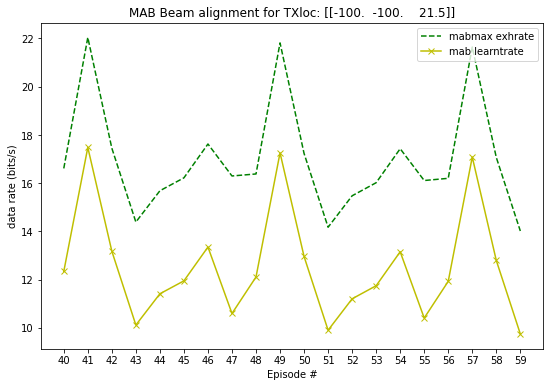

In [15]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
plt.plot(np.arange(len(mabtest_datarates[min_ndx:max_ndx])), mabtestmax_exhrates[min_ndx:max_ndx], 'g--', np.arange(len(mabtest_datarates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['mabmax exhrate', 'mab learntrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('MAB Beam alignment for TXloc: {}'.format(selected_loc))
plt.show()

import math
N = 1000*9
d = env.action_space.n
selected_actions = []

Qvals = [0]*d
num_selections = [0]*d 
total_rwd = 0
alpha=0.7

EPS_EVERY = 1000
indices = [(0,0),(0,1),(0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
x_ndx, y_ndx = 0,0

for n in range(N):
    action_ndx = env.reset(x_ndx,y_ndx)
    max_upperbound =0
    for i in range(d):
        if(num_selections[i] > 0):
            avg_rwd = Qvals[i]/num_selections[i]
            delta_i = math.sqrt(2*math.log(n+1)/num_selections[i])
            upper_bound = (1-alpha)*avg_rwd + (alpha)*delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upperbound:
            max_upperbound = upper_bound
            action_ndx = i
    
    selected_actions.append(action_ndx)
    num_selections[action_ndx] += 1
    rwd, done = env.step(action_ndx)
    Qvals[action_ndx] += rwd
    total_rwd += rwd
    #print(n)
    if (n+1)%EPS_EVERY == 0:
        env.reset(x_ndx,y_ndx)
        best_action_ndx = Qvals.index(max(Qvals))
        best_tx_dir_ndx = int(best_action_ndx/env.N_tx)
        best_rx_dir_ndx = int(best_action_ndx%env.N_rx)

        rwd, done = env.step(best_action_ndx)
        print("best beam pair for tx_loc {}:({}, {}), reward: {}".format(env.tx_loc, env.BeamSet[best_tx_dir_ndx]*180/np.pi ,env.BeamSet[best_rx_dir_ndx]*180/np.pi, rwd))
    
        if((n+1) < N):
            x_ndx,y_ndx = indices[int((n+1)/EPS_EVERY)][0], indices[int((n+1)/EPS_EVERY)][1]
        
print("total rwd after {} episodes: {}".format(N,total_rwd))